<a href="https://colab.research.google.com/github/data-tamer2410/ds-fashion_mnist_classifier/blob/main/fashion_mnist_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task.

We need to create a neural network using Keras mechanisms that will classify products from the fasion_mnist dataset.

It is up to you to propose your own network architecture.  The accuracy of your model should not be lower than 91%.

# Solving the task.

In [31]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

## Data loading and preparation.

In [69]:
from keras.datasets import fashion_mnist

In [70]:
(train_data,train_targets),(test_data,test_targets) = fashion_mnist.load_data()

In [71]:
train_data.shape

(60000, 28, 28)

The dataset consists of black and white images of clothing and shoes, where each image is represented as a 28 x 28 pixel matrix. Each pixel value ranges from 0 to 255, indicating its intensity. To train the model effectively, we need to convert these matrices into feature vectors.

In [72]:
train_targets.dtype

dtype('uint8')

In [73]:
n_cls = np.unique(train_targets).size #Number of classes.
n_cls

10

In [74]:
# Adjust the image format.
train_data = train_data.reshape((-1,(28 * 28)),).astype('float32')
test_data = test_data.reshape((-1,(28 * 28)),).astype('float32')

train_data.shape

(60000, 784)

In [75]:
# We normalize the features and convert the target values ​​to a convenient format.
train_data = train_data / 255
test_data = test_data / 255

train_targets = train_targets.astype('float32')
test_targets = test_targets.astype('float32')

In [76]:
# Let's divide the training data into training and validation data.
train_data, val_data, train_targets, val_targets = train_test_split(train_data,train_targets,test_size=0.15,stratify=train_targets)

## Building, selecting hyperparameters and testing the model.

In [10]:
import optuna
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam

**Selection of hyperparameters using Optuna.**

With the help of this library, we will select the network architecture (number of layers and neurons), number of epochs, batch size,
optimizer and activation function.

To find the optimal parameters, I will conduct tests several times gradually changing the range of parameters to find the best hyperparameters.

In [ ]:
def objective(trial):
    activation = trial.suggest_categorical('activation',['sigmoid','relu','tanh'])
    optimizer = trial.suggest_categorical('optimizer',['rmsprop','adam','nadam','adamax','amsgrad'])
    optimizer = Adam(amsgrad=True) if optimizer == 'amsgrad' else optimizer
    batch_size = trial.suggest_int('batch_size',730,845)
    n_epochs = trial.suggest_int('n_epochs',40,70)

    model = Sequential([
        Input((train_data.shape[1],)),
        Dense(trial.suggest_int('units_0',135,180),activation=activation),
        Dense(n_cls,activation='softmax')
    ])

    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy')

    model.fit(train_data,
              train_targets,
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=0
              )

    loss = model.evaluate(test_data,test_targets,batch_size=batch_size,verbose=0)
    return loss


study = optuna.create_study(direction='minimize',pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials=50,n_jobs=-1,show_progress_bar=True)

In [31]:
print(f"Best value: {study.best_value}\nBest params: {study.best_params}")

Best value: 0.31716859340667725
Best params: {'activation': 'tanh', 'optimizer': 'amsgrad', 'batch_size': 782, 'n_epochs': 45, 'units_0': 172}


In [64]:
# Hyperparameters
activation = 'tanh'
optimizer = Adam(amsgrad=True)
batch_size = 782
n_epochs = 45

In [ ]:
model = Sequential([
    Input(shape=(train_data.shape[1],)),
    Dense(172,activation=activation),
    Dense(n_cls,activation='softmax')
])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

history = model.fit(train_data,
                    train_targets,
                    batch_size=batch_size,
                    epochs=n_epochs,
                    validation_data=(val_data,val_targets))

In [23]:
history = history.history
print(f"Accuracy: {history['accuracy'][-1]:.2%}\n"
      f"Loss: {history['loss'][-1]:.6f}\n"
      f"Val-accuracy: {history['val_accuracy'][-1]:.2%}\n"
      f"Val-loss: {history['val_loss'][-1]:.6f}")

Accuracy: 93.24%
Loss: 0.190623
Val-accuracy: 89.44%
Val-loss: 0.297765


As we can see, the accuracy of our network reaches 93.24%, which indicates that the condition of the task has been successfully fulfilled.

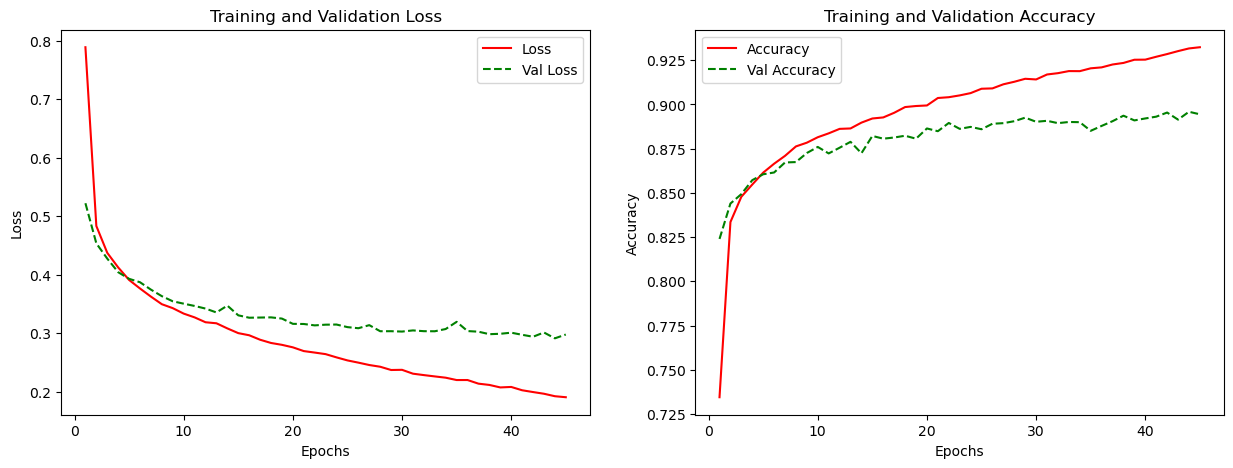

In [24]:
# Let's plot the function of loss and accuracy for training and validation data depending on the epochs.
import matplotlib.pyplot as plt
%matplotlib inline

x = range(1, len(history["loss"]) + 1)


fig, axs = plt.subplots(ncols=2,figsize=(15,5))

axs[0].plot(x,history['loss'],'r-',label='Loss')
axs[0].plot(x,history['val_loss'],'g--',label='Val Loss')

axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()

axs[1].plot(x,history['accuracy'],'r-',label='Accuracy')
axs[1].plot(x,history['val_accuracy'],'g--',label='Val Accuracy')

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()

plt.show()

In [83]:
# Testing model.
model.evaluate(test_data,test_targets,batch_size=batch_size)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8830 - loss: 0.3338 


[0.32937899231910706, 0.8833000063896179]

In [88]:
# We compare network predictions with target values.
n_test_imgs = test_targets.size

indices = np.random.choice(n_test_imgs,size=10,replace=False)
x_test_10 = test_data[indices]
y_test_10 = test_targets[indices]

y_pred_proba = model.predict(x_test_10)
y_pred = tf.argmax(y_pred_proba,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


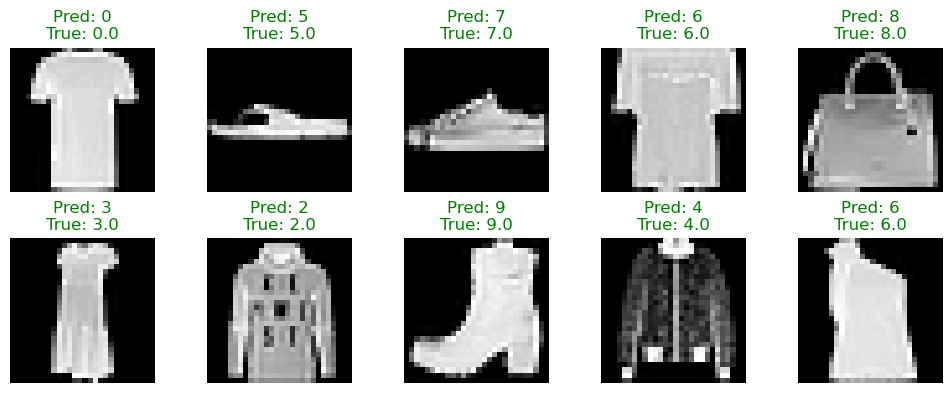

In [91]:
num_images_in_row = 5
rows = 2

plt.figure(figsize=(10, 2 * rows))

total_images = num_images_in_row * rows

for i in range(total_images):
    true_label = y_test_10[i]
    predicted_label = y_pred[i]

    plt.subplot(rows, num_images_in_row, i + 1)

    plt.imshow(x_test_10[i].reshape((28,28)), cmap="gray")
    plt.axis("off")

    plt.title(f"Pred: {predicted_label}\nTrue: {true_label}",
              color="green" if predicted_label == true_label else "red")

plt.tight_layout()
plt.show()

# Conclusion.

### **English**

---

Our neural network achieved an impressive accuracy of 93.24% on the training set and 89.44% on the validation set, confirming the model’s strong performance and generalization ability. The final evaluation on the test set resulted in 88.3% accuracy with a loss of 0.3338, which is satisfactory for the given task. This outcome meets the project’s goal of achieving a minimum 91% accuracy, demonstrating the success of hyperparameter tuning with Optuna and a well-designed architecture.

### **Ukrainian**

---

Висновок українською мовою: Наша нейронна мережа досягла чудової точності 93.24% на тренувальному наборі та 89.44% на валідаційному, що підтверджує її високу продуктивність та здатність до узагальнення. Оцінка на тестовому наборі показала точність 88.3% із втратою 0.3338, що є задовільним для поставленого завдання. Результат відповідає меті проєкту — досягти точності не нижче 91%, що демонструє успішність підбору гіперпараметрів за допомогою Optuna та обґрунтованість обраної архітектури.